In [1]:
cd /home

In [4]:
import tensorflow as tf
import pandas as pd 

import matplotlib.pyplot as plt

import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

from src.data.loaders import get_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## RECORDS

In [53]:
loader = get_loader(dataset=os.path.join('./data/records/atlas/fold_0/atlas_20/', 'val'), 
                         batch_size=1, 
                         probed_frac=.2,
                         random_frac=.0,  
                         window_size=200,
                         nsp_prob=.0,
                         max_gap=0.2,
                         repeat=1, 
                         shuffle=False,
                         sampling=True,
                         aversion='gap')

[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking


magnitudes (1, 200, 1)
times (1, 200, 1)
att_mask (1, 200, 1)
seg_emb (1, 200, 1)
-
magnitudes (1, 200, 1)
error (1, 200, 1)
probed_mask (1, 200, 1)
gap_dt (1,)
gap_0 (1,)
gap_1 (1,)
pad_mask (1, 200, 1)
gap_mask (1, 200, 1)


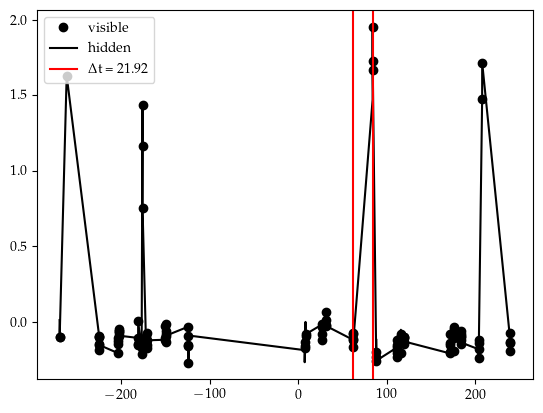

In [54]:
from src.data.gap import set_gap_prediction
for x, y in loader.take(1):
    
    for key in x.keys():
        print(key, x[key].shape)
    print('-')
    for key in y.keys():
        print(key, y[key].shape)

    x_time = tf.boolean_mask(x['times'][0], 1.-x['att_mask'][0])
    x_magn = tf.boolean_mask(x['magnitudes'][0], 1.-x['att_mask'][0])
    
    plt.plot(x_time, x_magn, color='k', marker='o', linestyle='', label='visible')

    xo_time = tf.boolean_mask(x['times'][0], y['pad_mask'][0])
    xo_magn = tf.boolean_mask(x['magnitudes'][0], y['pad_mask'][0])
    
    plt.plot(xo_time, xo_magn, color='k',linestyle='-', label='hidden')  
    
    plt.axvline(x=y['gap_0'][0], color='r')
    plt.axvline(x=y['gap_1'][0], color='r', label=r'$\Delta$t = {:.2f}'.format(y['gap_dt'][0]))   

    plt.legend(loc='upper left')    

In [18]:
# for x in loader.take(1):
#     out = randomize_v2(x, nsp_prob=1.)
#     plt.title('{}'.format(out['nsp_label'][0]))
    
#     x_nsp = tf.boolean_mask(out['nsp_input'][0], out['nsp_pad_mask'][0])
#     x_ori = tf.boolean_mask(out['input'][0], out['mask'][0])
    
#     plt.plot(x_nsp[:, 0], x_nsp[:, 1], marker='.')
#     plt.plot(x_ori[:, 0], x_ori[:, 1])


dict_keys(['magnitudes', 'error', 'original', 'probed_mask', 'seg_emb', 'nsp_label'])
tf.Tensor(
[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]], shape=(10, 1), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
(10,)


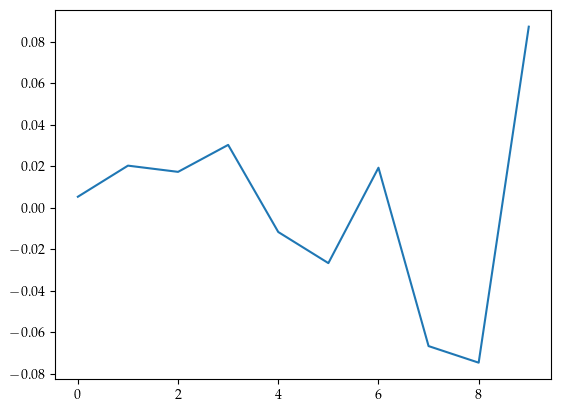

In [19]:
for x, y in loader.take(1):
    print(y.keys())
    print(x['seg_emb'][0])
    print(y['nsp_label'][0])
    x_valid = tf.boolean_mask(y['magnitudes'][0], 1. - x['att_mask'][0])
    print(x_valid.shape)
    plt.plot(x_valid)

In [168]:
from src.data.zero import pretraining_pipeline

test_loader_0 = pretraining_pipeline(os.path.join('./data/records/atlas/fold_0/atlas_20/', 'train'),
                                    batch_size=1,
                                    window_size=1000,
                                    shuffle=False,
                                    sampling=False,
                                    msk_frac=.5,
                                    rnd_frac=.2,
                                    same_frac=.2,
                                    return_ids=True)
    

[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


tf.Tensor(b'86991112522104263', shape=(), dtype=string)
(1, 1000, 1)
(120,)


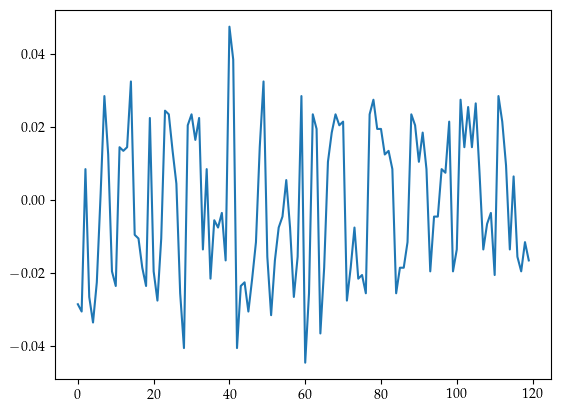

In [173]:
for x, y in test_loader_0.take(1):
    print(x['ids'][0])
    print(x['input'].shape)
    x_valid = tf.boolean_mask(x['input'][0], 1. - x['mask_in'][0])
    print(x_valid.shape)
    plt.plot(x_valid)

In [150]:
import numpy as np
plt.figure(figsize=(5, 3), dpi=200)
for x, y in data.take(1):
    
    N = 1
    start = 0 if off_nsp else 1

    original_lc   = x['original'][N]
    originak_mask = x['mask'][N]
    x_magn        = x['magnitudes'][N, start:, 0]
    x_time        = x['times'][N, start:, 0]
    att_mask      = x['att_mask'][N, start:, 0]        
    y_magn        = y['magnitudes'][N, :, 0]
    probed_mask   = y['probed_mask'][N, :, 0]
    
    # ASTROMER INPUT 
    magn_visible = tf.boolean_mask(x_magn, 1.-att_mask)    
    times_visible = tf.boolean_mask(x_time, 1.-att_mask)     
    magn_masked = tf.boolean_mask(x_magn, att_mask)
    times_masked = tf.boolean_mask(x_time, att_mask)
        
    # ASTROMER OUTPUT    
    x_probed = tf.boolean_mask(y_magn, probed_mask)
    time_probed=tf.boolean_mask(x_time, probed_mask)
    
    plt.plot(x_time, y_magn, linestyle='-', marker='s', 
             markersize=1,
             linewidth=0.5, color='k')
    
    plt.scatter(time_probed, x_probed, marker='*', 
                s=25, color='k', label='target')  
    plt.scatter(times_visible, magn_visible, marker='o', 
                s=7, color='g', label='visible')
    plt.scatter(times_masked, magn_masked, marker='s', 
                s=7, color='r', label='hidden', alpha=0.6)
  

    original_lc = tf.boolean_mask(original_lc, originak_mask)
    oritinal_time = tf.boolean_mask(x_time, originak_mask) 
    
    plt.plot(oritinal_time, original_lc[:, 1], linestyle='-', marker='s', 
             markersize=1,
             linewidth=0.5, color='y')
    
    plt.legend()

    if not off_nsp:
        if y['nsp_label'][N] == 1:
            plt.title('Non-Altered')
        else:
            plt.title('Altered')

NameError: name 'data' is not defined

<Figure size 1000x600 with 0 Axes>